<a href="https://colab.research.google.com/github/FaizalLeviansyah/Machine_Learning-2023/blob/main/Week_10_ML_Faizal_Lab_Work_Module10_Recurrent_Neural_Network(RNN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Praktikum 1
**RNN untuk Analisis Sentimen**

Setup


In [ ]:
# impor matplotlib dan buat fungsi pembantu untuk memplot grafik:
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf

tfds.disable_progress_bar()

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

Setup input pipeline
Dataset ulasan film IMDB adalah kumpulan data klasifikasi biner—semua ulasan memiliki sentimen positif atau negatif.

Download dataset menggunakan TFDS. Lihat loading text tutorial jika ingin me load data secara manual

In [ ]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [ ]:
# Awalnya ini mengembalikan dataset (teks, pasangan label):
for example, label in train_dataset.take(1):
  print('text: ', example.numpy())
  print('label: ', label.numpy())

text:  b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it."
label:  0


In [ ]:
# Berikutnya acak data untuk pelatihan dan membuat kumpulan pasangan (teks, label) ini:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b'Having not seen all the films released in 2002, I can\'t say that this is the best film of the year. I can say that it is the best film I have seen all year. <br /><br />Most American films featuring black people either obsess over the American preoccupation with "race relations", or fall into the cliches of the inner city ghetto, with every sterotype imaginable spouting ebonic-phrased slang. Antwone Fisher stands proudly alone in this regard: race is irrelevant, save for one fight that may, or may not, have been provoked by a racial slur.<br /><br />Antwone Fisher\'s story is one that should find resonance with any empathic individual. He is understatedly, and thoughtfully, portrayed by Derek Luke. Denzel Washington, while obviously using his star power to have the film made, sticks to the background for the most part, and allows the film to be the Antwone Fisher story. <br /><br />At a time when BET, and popular culture in general want to maintain the ghetoization of a lar

**Buat Teks Encoder**

In [ ]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())
vocab[:20]

array(['', '[UNK]', 'the', 'and', 'a', 'of', 'to', 'is', 'in', 'it', 'i',
       'this', 'that', 'br', 'was', 'as', 'for', 'with', 'movie', 'but'],
      dtype='<U14')

In [ ]:
# Setelah kosakata diatur, lapisan dapat mengkodekan teks ke dalam indeks. Tensor indeks diberi bantalan 0 ke urutan terpanjang dalam batch (kecuali jika Anda menetapkan output_sequence_length tetap):
encoded_example = encoder(example)[:3].numpy()
encoded_example

array([[252,  22, 108, ...,   0,   0,   0],
       [893, 142,   1, ...,   2, 115,   1],
       [  2,  64,  59, ...,   0,   0,   0]])

In [ ]:
# Dengan pengaturan default, prosesnya tidak dapat dibalik sepenuhnya. Ada dua alasan utama untuk itu:
# -Nilai default untuk argumen standarisasi preprocessing.TextVectorization adalah "lower_and_strip_punctuation".
# -Ukuran kosa kata yang terbatas dan kurangnya fallback berbasis karakter menghasilkan beberapa token yang tidak diketahui.
for n in range(3):
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b'Having not seen all the films released in 2002, I can\'t say that this is the best film of the year. I can say that it is the best film I have seen all year. <br /><br />Most American films featuring black people either obsess over the American preoccupation with "race relations", or fall into the cliches of the inner city ghetto, with every sterotype imaginable spouting ebonic-phrased slang. Antwone Fisher stands proudly alone in this regard: race is irrelevant, save for one fight that may, or may not, have been provoked by a racial slur.<br /><br />Antwone Fisher\'s story is one that should find resonance with any empathic individual. He is understatedly, and thoughtfully, portrayed by Derek Luke. Denzel Washington, while obviously using his star power to have the film made, sticks to the background for the most part, and allows the film to be the Antwone Fisher story. <br /><br />At a time when BET, and popular culture in general want to maintain the ghetoization of a l

In [ ]:
# Buat Model

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [ ]:
print([layer.supports_masking for layer in model.layers])

[False, True, True, True, True]


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions[0])

1/1 [==============================] - 8s 8s/step
[-0.00435071]


In [ ]:
# predict on a sample text with padding

padding = "the " * 2000
predictions = model.predict(np.array([sample_text, padding]))
print(predictions[0])

1/1 [==============================] - 0s 68ms/step
[-0.00435071]


In [ ]:
# compile model Keras untuk mengonfigurasi proses pelatihan:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
# Train Model
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 56s 112ms/step - loss: 0.6605 - accuracy: 0.5398 - val_loss: 0.5276 - val_accuracy: 0.7266
Epoch 2/10
391/391 [==============================] - 28s 71ms/step - loss: 0.4433 - accuracy: 0.7943 - val_loss: 0.3999 - val_accuracy: 0.8188
Epoch 3/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3722 - accuracy: 0.8371 - val_loss: 0.3674 - val_accuracy: 0.8411
Epoch 4/10
391/391 [==============================] - 27s 67ms/step - loss: 0.3387 - accuracy: 0.8528 - val_loss: 0.3461 - val_accuracy: 0.8349
Epoch 5/10
391/391 [==============================] - 28s 70ms/step - loss: 0.3177 - accuracy: 0.8656 - val_loss: 0.3257 - val_accuracy: 0.8557
Epoch 6/10
391/391 [==============================] - 27s 69ms/step - loss: 0.3103 - accuracy: 0.8697 - val_loss: 0.3250 - val_accuracy: 0.8578
Epoch 7/10
391/391 [==============================] - 27s 68ms/step - loss: 0.3042 - accuracy: 0.8718 - val_loss: 0.3250 - val_accuracy

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 20s 50ms/step - loss: 0.3163 - accuracy: 0.8616
Test Loss: 0.31628841161727905
Test Accuracy: 0.8615599870681763


(0.0, 0.6786168083548546)

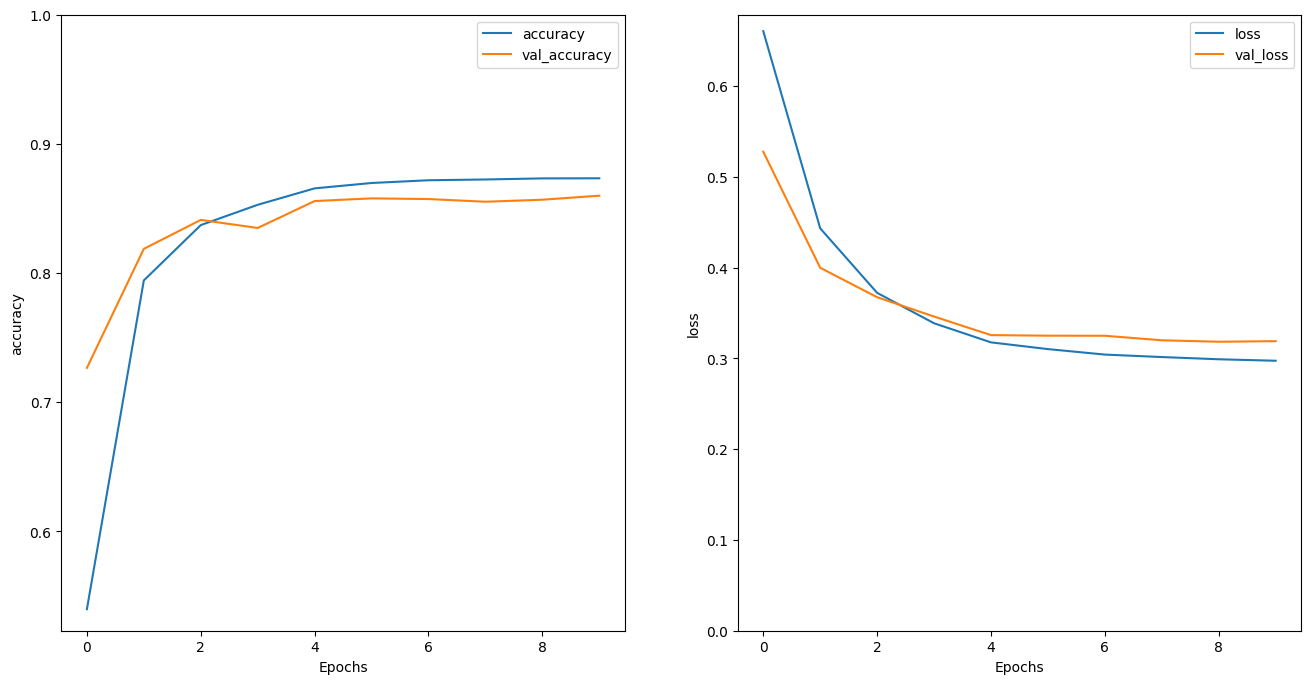

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [ ]:
# Jalankan prediksi pada kalimat baru:
# Jika prediksi >= 0,0 berarti positif, jika tidak maka negatif.
sample_text = ('The movie was cool. The animation and the graphics '
               'were out of this world. I would recommend this movie.')
predictions = model.predict(np.array([sample_text]))

1/1 [==============================] - 3s 3s/step


**Stack two or more LSTM layers**

In [ ]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 84s 161ms/step - loss: 0.6469 - accuracy: 0.5710 - val_loss: 0.4691 - val_accuracy: 0.7734
Epoch 2/10
391/391 [==============================] - 64s 162ms/step - loss: 0.4008 - accuracy: 0.8258 - val_loss: 0.3570 - val_accuracy: 0.8432
Epoch 3/10
391/391 [==============================] - 57s 145ms/step - loss: 0.3382 - accuracy: 0.8550 - val_loss: 0.3373 - val_accuracy: 0.8328
Epoch 4/10
391/391 [==============================] - 52s 133ms/step - loss: 0.3232 - accuracy: 0.8626 - val_loss: 0.3292 - val_accuracy: 0.8479
Epoch 5/10
391/391 [==============================] - 59s 149ms/step - loss: 0.3153 - accuracy: 0.8651 - val_loss: 0.3226 - val_accuracy: 0.8505
Epoch 6/10
391/391 [==============================] - 54s 138ms/step - loss: 0.3076 - accuracy: 0.8710 - val_loss: 0.3198 - val_accuracy: 0.8542
Epoch 7/10
391/391 [==============================] - 49s 124ms/step - loss: 0.3017 - accuracy: 0.8729 - val_loss: 0.3262 - val_ac

In [ ]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)

391/391 [==============================] - 21s 54ms/step - loss: 0.3132 - accuracy: 0.8618
Test Loss: 0.3131527602672577
Test Accuracy: 0.8618000149726868


In [ ]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
               'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

1/1 [==============================] - 6s 6s/step
[[-2.0757918]]


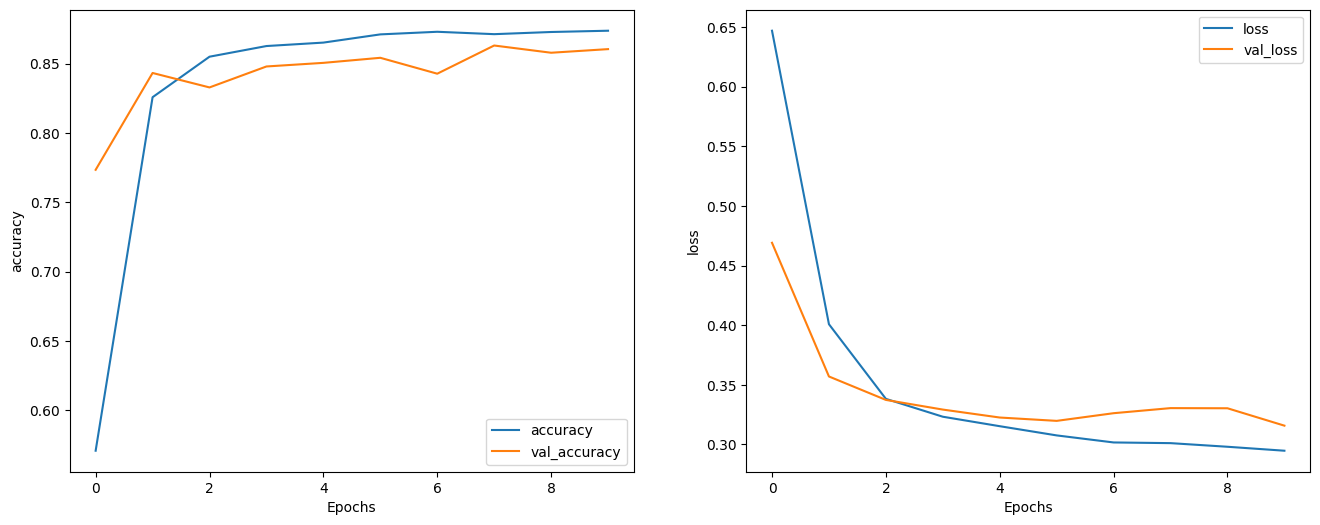

In [ ]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')

# Praktikum 2
Generator Teks dengan RNN

In [ ]:
# Import TensorFlow
import tensorflow as tf
import numpy as np
import os
import time

**Download Dataset Shakespeare**

Sesuaikan dengan lokasi data yang Anda punya.

In [ ]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

1115394/1115394 [==============================] - 0s 0us/step


**Load Data**

In [ ]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [ ]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [ ]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')

65 unique characters


# Olah Teks
# Vectorize Teks
Sebelum training, Anda perlu mengonversi string menjadi representasi numerik. tf.keras.layers.StringLookup dapat mengubah setiap karakter menjadi ID numerik. Caranya adalah teks akan dipecah menjadi token terlebih dahulu.

In [ ]:
example_texts = ['abcdefg', 'xyz']
chars = tf.strings.unicode_split(example_texts, input_encoding='UTF-8')
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

sekarang buat tf.keras.layers.StringLookup layer:

In [ ]:
ids_from_chars = tf.keras.layers.StringLookup(
    vocabulary=list(vocab), mask_token=None
)

perintah diatas mengconvert token menjadi id

In [ ]:
ids = ids_from_chars(chars)
ids

<tf.RaggedTensor [[40, 41, 42, 43, 44, 45, 46], [63, 64, 65]]>

In [ ]:
chars_from_ids = tf.keras.layers.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)

In [ ]:
chars = chars_from_ids(ids)
chars

<tf.RaggedTensor [[b'a', b'b', b'c', b'd', b'e', b'f', b'g'], [b'x', b'y', b'z']]>

In [ ]:
tf.strings.reduce_join(chars, axis=-1).numpy()

array([b'abcdefg', b'xyz'], dtype=object)

In [ ]:
def text_from_ids(ids):
    return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

Prediksi

Diberikan sebuah karakter, atau serangkaian karakter, karakter apa yang paling mungkin berikutnya? Ini adalah tugas yang harus Anda latih agar model dapat melakukannya. Masukan ke model akan berupa urutan karakter, dan Anda melatih model untuk memprediksi keluaran berupa karakter berikut pada setiap langkah waktu. Karena RNN mempertahankan keadaan internal yang bergantung pada elemen yang terlihat sebelumnya, mengingat semua karakter dihitung hingga saat ini, karakter apa selanjutnya?

Membuat Trianing Set dan Target
Selanjutnya bagilah teks menjadi contoh sequence. Setiap masukan sequence akan berisi karakter seq_length dari teks. Untuk setiap masukan sequence, target prediksi berisi teks dengan panjang yang sama, hanya digeser satu karakter ke kanan. Jadi, bagi teks menjadi beberapa bagian seq_length+1. Misalnya, seq_length adalah 4 dan teks kita adalah "Hello". Urutan masukannya adalah "Hell", dan urutan targetnya adalah "ello". Untuk melakukan ini, pertama-tama gunakan fungsi tf.data.Dataset.from_tensor_slices untuk mengonversi vektor teks menjadi aliran indeks karakter.

In [ ]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))

In [ ]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [ ]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [ ]:
seq_length = 100

Metode batch memungkinkan Anda dengan mudah mengonversi karakter individual ini menjadi urutan ukuran yang diinginkan.

In [ ]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


In [ ]:
# akan lebih mudah untuk melihat apa yang dilakukan jika Anda menggabungkan token kembali menjadi string:
for seq in sequences.take(5):
    print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


Untuk pelatihan, Anda memerlukan kumpulan data pasangan (input, label). Dimana input dan label merupakan urutan. Pada setiap langkah waktu, inputnya adalah karakter saat ini dan labelnya adalah karakter berikutnya. Berikut adalah fungsi yang mengambil urutan sebagai masukan, menduplikasi, dan menggesernya untuk menyelaraskan masukan dan label untuk setiap langkah waktu:

In [ ]:
def split_input_target(sequence):
    input_text = sequence[:-1]
    target_text = sequence[1:]
    return input_text, target_text

In [ ]:
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [ ]:
dataset = sequences.map(split_input_target)

In [ ]:
for input_example, target_example in dataset.take(1):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '


# Membuat Batch Training
Anda menggunakan tf.data untuk membagi teks menjadi sequence yang dapat diatur. Namun sebelum memasukkan data ini ke dalam model, Anda perlu mengacak data dan mengemasnya ke dalam batch.

In [ ]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 100), dtype=tf.int64, name=None), TensorSpec(shape=(64, 100), dtype=tf.int64, name=None))>

# Buat Model

Bagian ini mendefinisikan model sebagai subkelas keras.Model (untuk lebih detilnya, lihat Making new Layers and Models via subclassing).
Model yang kita bangun memiliki 3 lapisan neural network :
- tf.keras.layers.Embedding: Lapisan masukan. Tabel pencarian yang dapat dilatih yang akan memetakan setiap karakter-ID ke vektor dengan dimensi embedding_dim;
- tf.keras.layers.GRU: lapisan RNN dengan ukuran unit=rnn_units (Anda juga dapat menggunakan lapisan LSTM di sini.)
- tf.keras.layers.Dense: Lapisan keluaran, dengan keluaran vocab_size. Ini menghasilkan satu logit untuk setiap karakter dalam kosakata. Ini adalah log kemungkinan setiap karakter menurut model.

In [ ]:
# Length of the vocabulary in StringLookup Layer
vocab_size = len(ids_from_chars.get_vocabulary())

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [ ]:
class MyModel(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [ ]:
model = MyModel(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

# Uji Model
Coba jalankan model dan cek apakah sidah sesuai dengan output
pertama, cek bentuk dari output

In [ ]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [ ]:
# Dalam contoh di atas, panjang urutan masukan adalah 100 tetapi model dapat dijalankan pada masukan dengan panjang berapa pun:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     multiple                  16896     
                                                                 
 gru (GRU)                   multiple                  3938304   
                                                                 
 dense_6 (Dense)             multiple                  67650     
                                                                 
Total params: 4022850 (15.35 MB)
Trainable params: 4022850 (15.35 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#Untuk mendapatkan prediksi aktual dari model, Anda perlu mengambil sampel dari distribusi keluaran, untuk mendapatkan indeks karakter aktual. Distribusi ini ditentukan oleh logit pada kosakata karakter. Catatan: Penting untuk mengambil sampel dari distribusi ini karena mengambil argmax dari distribusi tersebut dapat dengan mudah membuat model terjebak dalam infinote loop. Cobalah untuk contoh pertama di batch:
sampled_indices = tf.random.categorical(example_batch_predictions[0], num_samples=1)
sampled_indices = tf.squeeze(sampled_indices, axis=-1).numpy()

In [ ]:
# Hal ini memberi kita, pada setiap langkah waktu, prediksi indeks karakter berikutnya:
sampled_indices

array([ 4, 20, 42, 55, 64,  3, 43, 61, 37, 48, 57, 45,  4, 20, 17, 55, 51,
       31, 42, 55, 33, 43, 25, 57, 47, 21, 31, 20, 57,  8, 14, 25, 23, 11,
       41, 46,  6,  8, 19, 14, 21, 12, 38,  5,  7, 39, 19, 45,  2,  8, 55,
       61, 10, 26, 40, 37, 10,  4, 24, 48, 59, 31,  1, 14, 26, 16, 21, 55,
       40,  9, 26, 51, 33,  3, 49,  6, 36, 34, 44, 28,  9, 59, 25, 35,  4,
       33, 61, 14, 57, 10, 24, 43, 46, 19, 50, 54,  0,  6,  4, 62])

In [ ]:
# Dekode kode berikut untuk melihat teks yang diprediksi oleh model tidak terlatih ini:
print("Input:\n", text_from_ids(input_example_batch[0]).numpy())
print()
print("Next Char Predictions:\n", text_from_ids(sampled_indices).numpy())

Input:
 b"g: being something\ngently considered, I'll bring you where he is\naboard, tender your persons to his "

Next Char Predictions:
 b"$Gcpy!dvXirf$GDplRcpTdLrhHRGr-ALJ:bg'-FAH;Y&,ZFf -pv3MaX3$KitR\nAMCHpa.MlT!j'WUeO.tLV$TvAr3KdgFko[UNK]'$w"


In [ ]:
# Tambahan optimizer dan fungsi loss
# loss function tf.keras.losses.sparse_categorical_crossentropy standar berfungsi dalam kasus ini karena diterapkan di seluruh dimensi terakhir prediksi. Karena model Anda mengembalikan logits, Anda perlu mengatur flag from_logits.
import tensorflow as tf

loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)
example_batch_mean_loss = loss(target_example_batch, example_batch_predictions)
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", example_batch_mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         tf.Tensor(4.1902285, shape=(), dtype=float32)


In [ ]:
tf.exp(example_batch_mean_loss).numpy()

66.03788

In [ ]:
model.compile(optimizer='adam', loss=loss)

# Konfigurasi Checkpoints
Gunakan tf.keras.callbacks.ModelCheckpoint untuk memastikan bahwa checkpoint disimpan selama pelatihan:

In [ ]:
# Directory where the checkpoints will be saved
checkpoint_dir = './training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

# Lakukan Proses Training
Agar waktu pelatihan tidak terlalu lama, gunakan 10 epoch untuk melatih model. Di Colab, setel runtime ke GPU untuk pelatihan yang lebih cepat.

In [ ]:
EPOCHS = 20

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

Epoch 1/20
172/172 [==============================] - 16s 56ms/step - loss: 2.7314
Epoch 2/20
172/172 [==============================] - 11s 54ms/step - loss: 1.9966
Epoch 3/20
172/172 [==============================] - 11s 55ms/step - loss: 1.7160
Epoch 4/20
172/172 [==============================] - 12s 56ms/step - loss: 1.5529
Epoch 5/20
172/172 [==============================] - 13s 56ms/step - loss: 1.4528
Epoch 6/20
172/172 [==============================] - 12s 57ms/step - loss: 1.3827
Epoch 7/20
172/172 [==============================] - 13s 57ms/step - loss: 1.3292
Epoch 8/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2840
Epoch 9/20
172/172 [==============================] - 12s 58ms/step - loss: 1.2418
Epoch 10/20
172/172 [==============================] - 13s 58ms/step - loss: 1.2022
Epoch 11/20
172/172 [==============================] - 12s 59ms/step - loss: 1.1625
Epoch 12/20
172/172 [==============================] - 12s 60ms/step - loss: 1.1208
E

In [ ]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

Jalankan secara berulang untuk menghasilkan beberapa teks. Melihat teks yang dihasilkan, Anda akan melihat model mengetahui kapan harus menggunakan huruf besar, membuat paragraf, dan meniru kosakata menulis seperti Shakespeare. Karena sedikitnya jumlah epoch pelatihan, model belum belajar membentuk kalimat runtut.

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(1000):
  # Assuming you have already defined the model named 'model'
  one_step_model = OneStep(model, chars_from_ids, ids_from_chars)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROMEO:ROME

In [ ]:
start = time.time()
states = None
next_char = tf.constant(['ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:', 'ROMEO:'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result, '\n\n' + '_'*80)
print('\nRun time:', end - start)

tf.Tensor(
[b"ROMEO:\nWho shall be done?\n\nSICINIUS:\nShe hath.\n\nBENVOLIO:\nWhy, what honouray's earth?\n\nPAULINA:\nThere is thy power, you must part contempt\nThat by desiring mistrust in my boot.\nBeing a noble fellows, sir, that Plantagenet\nShould wish for your eyes, and no less riter\nBoling the midest horse unto your sufficient\nYour coates move their hearts of mother; we came\nTo see the cofford of them, 'II' quoth de, Romeo.\n\nROMEO:\nCall me both the envious flood of mine than I,\nThe vaulty and Sixing it: come, take upon my son.\nShe is work to my silent fools.\n\nQUEEN ELIZABETH:\nWhat, will you go?\n\nDUKE VINCENTIO:\nAgainst my lord, this is come to few them; as their gracious\nYour recounter in his own deed? and his oils?\nWhat sabelys of thee? art thou the\nsee money?\n\nMENENIUS:\nI am they sat: there may be gracting with the\nthree penitent to many friends, it make returned\nuncappies the happy earth.\n\nLord Mayor:\nSee, where is that Bolingbroke does the bot!\n\

# Ekspor Model Generator
Model satu langkah ini dapat dengan mudah disimpan dan digunakan kembali, memungkinkan Anda menggunakannya di mana pun tf.saved_model diterima.

In [ ]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

In [ ]:
states = None
next_char = tf.constant(['ROMEO:', '', '', '', ''])  # Adjust the shape to (5,)
result = [next_char]

for n in range(100):
    next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
    result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))


ROMEO:
Great Aufidius, an a resolution to Polixenes
To any thing they have alive, the presency stark
From 


# Tugas

Custom Training Step (train_step method):

In [23]:
class CustomTraining(MyModel):
    @tf.function
    def train_step(self, inputs):
        inputs, labels = inputs
        with tf.GradientTape() as tape:
            predictions = self(inputs, training=True)
            loss = self.loss(labels, predictions)
        grads = tape.gradient(loss, model.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, model.trainable_variables))

        return {'loss': loss}